# Karpathy's Introduction to Backpropagation in Neural Networks

I really want to cement my understanding of backpropagation in neural networks after going through Manning's [Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 3 - Backprop and Neural Networks](https://www.youtube.com/watch?v=X0Jw4kgaFlg). 

From Karpathy's [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0) on YouTube.

NOTE: this will require the following libraries and/or packages...
- `graphviz` package for Linux, install with `sudo apt-get install graphviz`
- [`graphviz`](https://graphviz.readthedocs.io/en/stable/) - Python wrapper to `graphviz` package itself

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Intuition: Derivatives

#### Simple example: a function with a single input

Consider the simple function $f(x) = 3x^{2} - 4x + 5$.

In [2]:
# simple example: 1 input; a quadratic
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

What does that look like?

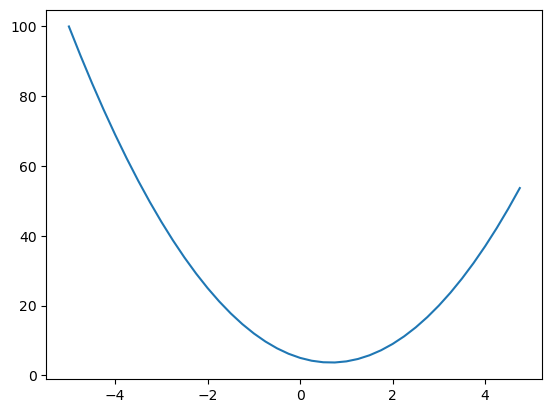

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

How does the slope of this function change at different inputs?

In [5]:
h = 0.0000001

# x = 3
# x = -3
x = 2/3

(f(x + h) - f(x)) / h

2.9753977059954195e-07

#### A more complex example: 3 inputs

Now see what happens to the slope of the function $f(x) = a * b + c$ when you increase the inputs individually by a small amount $h$.

In [6]:
# a more complex example: 3 inputs!
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs, fixed
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# a += h
# b += h
c += h

d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.0001
slope:  0.9999999999976694


----

In [8]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        """ + operator responder! """
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        """ * operator responder! """
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print(L)

Value(data=-8.0)


In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(
        format='svg',
        graph_attr={'rankdir': 'LR'}
    )
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            # and connect this node to it!
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connecty n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

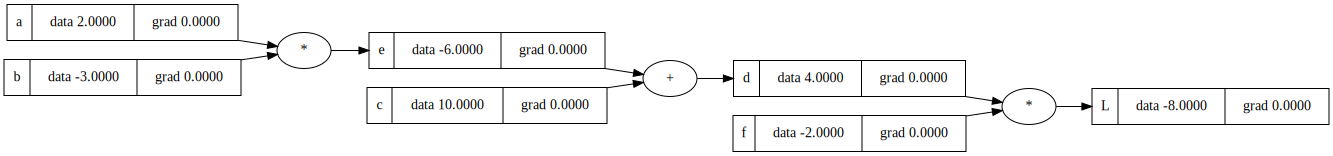

In [11]:
# we will calculate the gradients for each node manually right after this!

draw_dot(L)

### Back-prop by hand...

If you really are rusty, then scroll down to the Intuitive Explanation section of [the Wikipedia page on the Chain rule](https://en.wikipedia.org/wiki/Chain_rule).

But using our simple function graph above, it is really nothing more than this:

#### Starting from the far right

Calculate $\frac{dL}{dL}$

\begin{align}
\frac{dL}{dL} = 1
\end{align}

#### Moving to preceding multiplication operation

Since $L = d * f$ we calculate by the Chain rule:

\begin{align}
\frac{dL}{dd} = f = -2
\end{align}

... and ...

\begin{align}
\frac{dL}{df} = d = 4
\end{align}

#### Continuing backwards to the preceding addition operation

Since $d = e + c$ we calculate by the Chain rule:

\begin{align}
\frac{dL}{de} = \frac{dL}{dd} \frac{dd}{de} = -2 * 1 = -2
\end{align}

... and ...

\begin{align}
\frac{dL}{dc} = \frac{dL}{dd} \frac{dd}{dc} = -2 * 1 = -2
\end{align}

#### Finish moving backwards to the initial multiplication operation

Since $3 = a * b$ we calculate once more by the Chain rule:

\begin{align}
\frac{dL}{da} = \frac{dL}{de} \frac{de}{da} = -2 * -3 = 6
\end{align}

... and lastly ...

\begin{align}
\frac{dL}{db} = \frac{dL}{de} \frac{de}{db} = -2 * 2 = -4
\end{align}


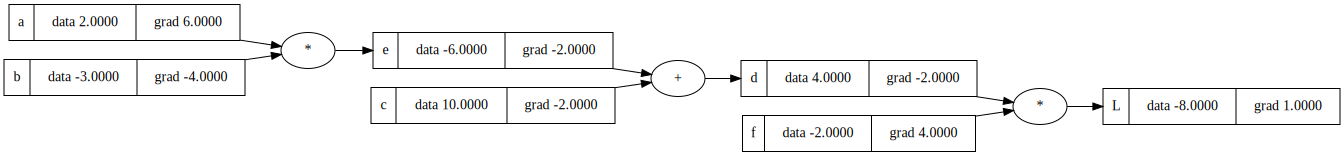

In [12]:
# OK, now let's manually initialize the gradients for the nodes in our function graph

L.grad = 1.0

d.grad = -2.0
f.grad =  4.0

c.grad = -2.0
e.grad = -2.0

a.grad =  6.0
b.grad = -4.0

draw_dot(L)

Nudging $a$, $b$, $c$ and $f$ _in the direction of the gradient_, we should then see an increase in $L$...

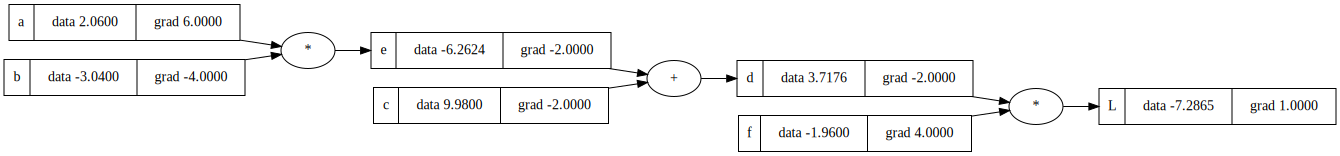

In [13]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e.data = a.data * b.data
d.data = e.data + c.data
L.data = d.data * f.data


#print(L.data)
draw_dot(L)

An interesting note, you may have noticed that with an _addition_ operation like $d = e + c$ above, the gradients flowing in are merely distributed to the child nodes at that layer.

You can see that using the following function.

In [14]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    
    c = Value(10.0, label='c')
    #c.data += h
    
    e = a*b; e.label = 'e'
    e.data += h
    
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1) / h)
    
lol()

-1.9999999999953388
